In [1]:
# 🔄 Uploader kaggle.json pour s'authentifier
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedbouba","key":"83a05b7b2627e5d668977064fe71d47b"}'}

In [2]:
# 🔐 Configuration Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 776M/778M [00:02<00:00, 258MB/s]
100% 778M/778M [00:02<00:00, 356MB/s]


In [4]:
!unzip -q covid19-radiography-database.zip -d data/

In [5]:
import os
print(os.listdir("data"))

['COVID-19_Radiography_Dataset']


In [6]:
# Pour Google Colab uniquement (décommente si besoin)
# !pip install tensorflow matplotlib scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
import os
import shutil

# Nouveau dossier bien structuré
target_base_dir = "/content/dataset"
os.makedirs(target_base_dir, exist_ok=True)

# Dossier source
source_base = "/content/data/COVID-19_Radiography_Dataset"

# Dictionnaire de mapping : dossier source -> dossier destination
mapping = {
    "COVID": "COVID",
    "Normal": "Normal",
    "Viral Pneumonia": "Pneumonia"  # renommé pour simplifier
    # "Lung_Opacity": "Opacity"  # tu peux l’ajouter si besoin
}

for original_folder, final_label in mapping.items():
    image_folder = os.path.join(source_base, original_folder, "images")
    destination_folder = os.path.join(target_base_dir, final_label)
    os.makedirs(destination_folder, exist_ok=True)

    for filename in os.listdir(image_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            src = os.path.join(image_folder, filename)
            dst = os.path.join(destination_folder, filename)
            shutil.copy(src, dst)

print("✅ Images copiées avec succès dans:", target_base_dir)


✅ Images copiées avec succès dans: /content/dataset


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

# 📏 Paramètres
img_size = (224, 224)
batch_size = 32
dataset_path = "/content/dataset"

# ✅ Générateur d'images AVEC AUGMENTATION pour le training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# 🔹 Sans augmentation pour la validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# 📥 Training data
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# 📥 Validation data
val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ✅ Générer class_weight pour compenser les classes déséquilibrées
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights_array))

# Affichage
print("🧮 Poids de classe calculés :", class_weights)


Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.
🧮 Poids de classe calculés : {0: np.float64(1.3968199101278949), 1: np.float64(0.4955849889624724), 2: np.float64(3.7555762081784385)}


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Construire le modèle final
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.6),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[earlystop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 190s 480ms/step - accuracy: 0.5157 - loss: 0.9571 - val_accuracy: 0.6393 - val_loss: 0.9120
Epoch 2/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 172s 454ms/step - accuracy: 0.6735 - loss: 0.5725 - val_accuracy: 0.7495 - val_loss: 0.5350
Epoch 3/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 170s 450ms/step - accuracy: 0.6905 - loss: 0.5192 - val_accuracy: 0.8007 - val_loss: 0.4525
Epoch 4/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 171s 452ms/step - accuracy: 0.7247 - loss: 0.4944 - val_accuracy: 0.8376 - val_loss: 0.4023
Epoch 5/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 170s 450ms/step - accuracy: 0.7429 - loss: 0.4564 - val_accuracy: 0.8403 - val_loss: 0.3970
Epoch 6/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 172s 453ms/step - accuracy: 0.7681 - loss: 0.4147 - val_accuracy: 0.7868 - val_loss: 0.4772
Epoch 7/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 173s 456ms/step - accuracy: 0.7804 - loss: 0.3865 - val_accuracy: 0.8723 - val_loss: 0.3422
Epoch 8/15
379/379 ━━━━━━━━━━━━━━━━━━━━ 174s 459ms/step - accuracy: 0.7902 -

/tmp/ipython-input-2647080416.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2647080416.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2647080416.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("accuracy_loss.png")
/tmp/ipython-input-2647080416.py:26: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("accuracy_loss.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  

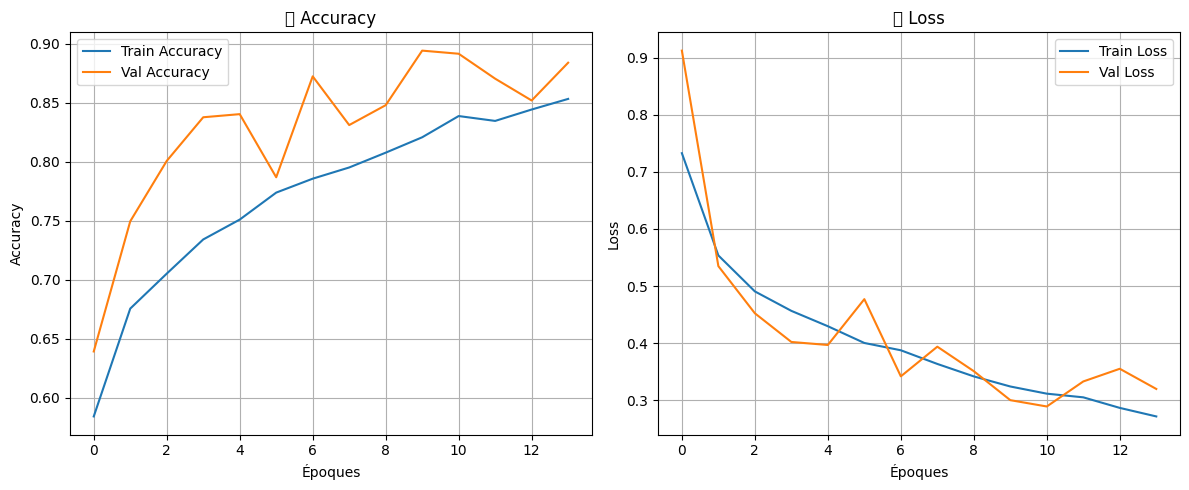

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Courbe Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("📈 Accuracy")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Courbe Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("📉 Loss")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("accuracy_loss.png")
plt.show()


95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step
📋 Rapport de classification :

              precision    recall  f1-score   support

       COVID       0.87      0.83      0.85       723
      Normal       0.94      0.91      0.92      2038
   Pneumonia       0.68      0.94      0.79       269

    accuracy                           0.89      3030
   macro avg       0.83      0.89      0.85      3030
weighted avg       0.90      0.89      0.89      3030



/tmp/ipython-input-2657623395.py:23: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2657623395.py:24: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.savefig("confusion_matrix.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


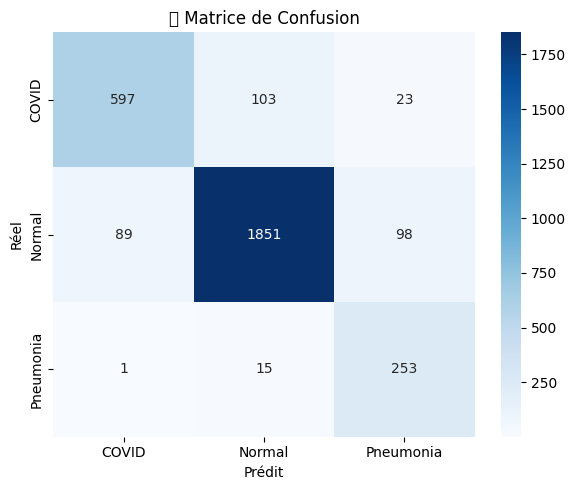

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Prédictions
val_data.reset()
y_pred = model.predict(val_data, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Rapport
print("📋 Rapport de classification :\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧾 Matrice de Confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [12]:
model.save("covid_model_2.keras")

In [13]:
files.download("covid_model_2.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>